In [3]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from sklearn import metrics
# Configure visualisations
% matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8, 6


In [4]:
# Read data
train = pd.read_csv('/home/arturx/PycharmProjects/KaggleTest/train.csv')
test = pd.read_csv('/home/arturx/PycharmProjects/KaggleTest/test.csv')

full = train.append(test,ignore_index=True)
titanic = full[:891]
del test,train      

In [5]:
# Functions for data visualization

def plot_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 12))
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=10, ax=ax)
        ax.set_title(
            'Skew: ' + str(round(float(df[var_name].skew()), )))  # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels([], visible=False)
        ax.set_yticklabels([], visible=False)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()

def plot_categories(df, cat, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, row=row, col=col)
    facet.map(sns.barplot, cat, target)
    facet.add_legend()

def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )

def describe_more(df):
    var = [];
    l = [];
    t = []
    for x in df:
        var.append(x)
        l.append(len(pd.value_counts(df[x])))
        t.append(df[x].dtypes)
    levels = pd.DataFrame({'Variable': var, 'Levels': l, 'Datatype': t})
    levels.sort_values(by='Levels', inplace=True)
    return levels

def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)

def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[: 10].plot(kind='barh')
    print (model.score(X, y))


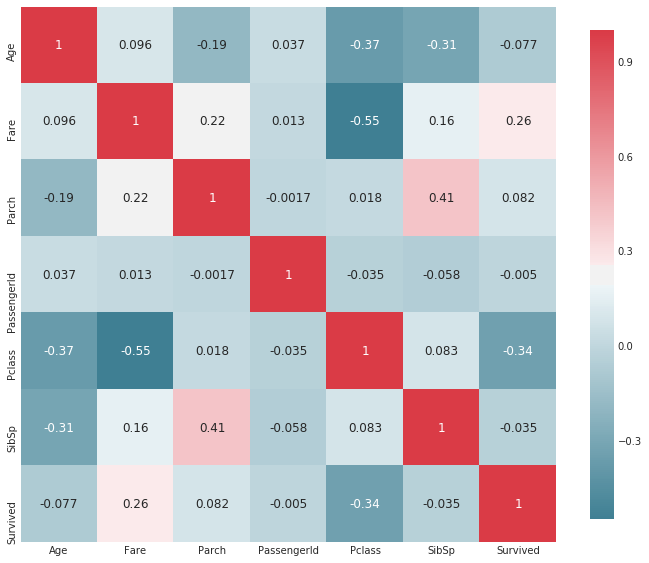

In [7]:
plot_correlation_map(titanic)

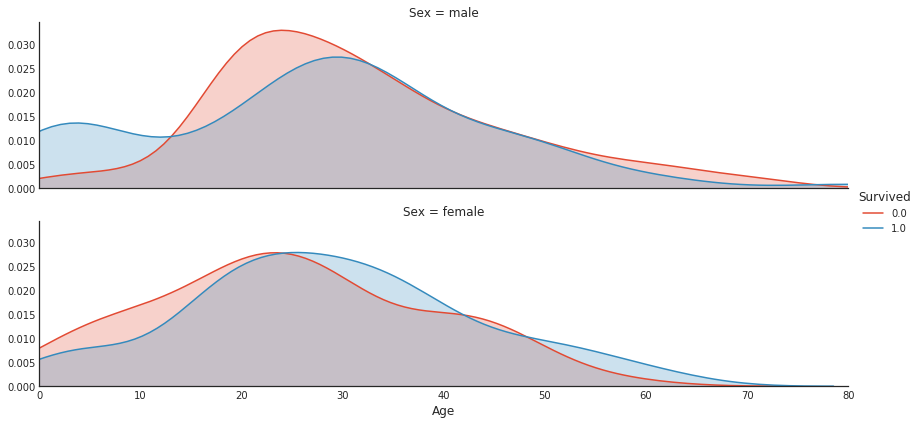

In [8]:
plot_distribution(titanic,var = 'Age',target= 'Survived',row='Sex')

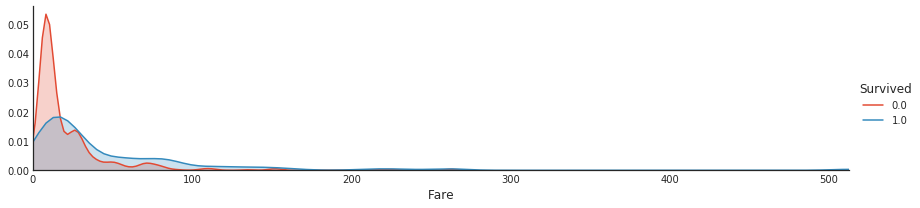

In [8]:
plot_distribution(titanic,var='Fare',target='Survived')

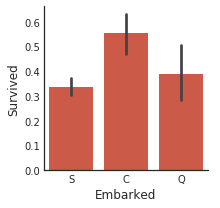

In [9]:
plot_categories(titanic,cat='Embarked',target='Survived')

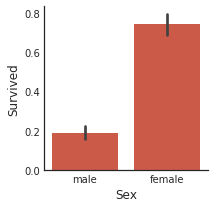

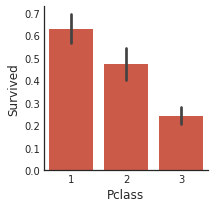

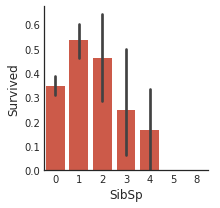

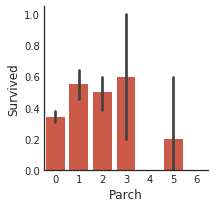

In [13]:
plot_categories(titanic, 'Sex', 'Survived')
plot_categories(titanic, 'Pclass', 'Survived')
plot_categories(titanic, 'SibSp', 'Survived')
plot_categories(titanic, 'Parch', 'Survived')


In [9]:
## IMP! Transform categorical variables

sex = pd.Series(np.where(full.Sex == 'male', 1, 0), name='Sex')
embarked = pd.get_dummies(full.Embarked, prefix='Embarked')
pclass = pd.get_dummies(full.Pclass, prefix='Pclass')

In [10]:
# Create a new DF, fill NotApplicable values with it's column's mean's
imputed = pd.DataFrame()
imputed['Age'] = full.Age.fillna(full.Age.mean())
imputed['Fare'] = full.Fare.fillna(full.Fare.mean())
imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [11]:
# Create a new Features
title = pd.DataFrame()
title['Title'] = full['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

title['Title'] = title.Title.map(title_Dictionary)
title = pd.get_dummies(title.Title)

In [12]:
cabin = pd.DataFrame()
# replacing missing cabins with u
cabin['Cabin'] = full.Cabin.fillna('U')
# mapping each cabin value with the cabin letter
cabin['Cabin'] = cabin['Cabin'].map(lambda c: c[0])
# dummy encoding
cabin = pd.get_dummies(cabin['Cabin'],prefix='Cabin')

In [13]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket['Ticket'] = full['Ticket'].map(cleanTicket)
ticket = pd.get_dummies(ticket['Ticket'], prefix='Ticket')


In [14]:
# create family size variables
family = pd.DataFrame()
family['FamilySize'] = full['Parch'] + full['SibSp'] + 1

family['Family_Single'] = family['FamilySize'].map(lambda s: 1 if s == 1 else 0)
family['Family_Small'] = family['FamilySize'].map(lambda s: 1 if 2 <= s <= 5 else 0)
family['Family_Big'] = family['FamilySize'].map(lambda s: 1 if s >= 5 else 0)


In [ ]:
# now putting all variables together!
full_X = pd.concat([imputed , embarked , pclass , sex , family , cabin , ticket],axis=1)

In [16]:
# creating train and validation sets
train_valid_X = full_X[0:891]
train_valid_y = titanic.Survived
test_X = full_X[891:]
train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size=.7)


In [22]:
models = [RandomForestClassifier(), SVC(), GradientBoostingClassifier(), GaussianNB(),
          KNeighborsClassifier(), LogisticRegression()]
for name, model in zip(
        ['RandomForest', 'SVC', 'GradBoosting', 'GaussianNaiveBayes', 'KNeighbors', 'LogisticRegression'], models):
    print "For model{} params are\n{}".format(name, model.get_params())
prf = {'max_leaf_nodes': np.arange(1, 10, 1),
       'n_estimators': np.arange(10, 1000, 10),
       'max_features': np.arange(1, 63, 8),
       'max_depth': np.arange(1, 100, 10)}
psvc = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
pgb = prf

pgnb = {}

pknn = {
    'n_neighbors': np.arange(1, 10, 1),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
plr = {
    'penalty': ['l1', 'l2'],
    'C': np.arange(0.01, 0.1, 0.02)
}
parameters = [prf, psvc, pgb, pgnb, pknn, plr]
from sklearn.grid_search import GridSearchCV

For modelRandomForest params are
{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'min_impurity_decrease': 0.0, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'min_impurity_split': None, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}
For modelSVC params are
{'kernel': 'rbf', 'C': 1.0, 'verbose': False, 'probability': False, 'degree': 3, 'shrinking': True, 'max_iter': -1, 'decision_function_shape': 'ovr', 'random_state': None, 'tol': 0.001, 'cache_size': 200, 'coef0': 0.0, 'gamma': 'auto', 'class_weight': None}
For modelGradBoosting params are
{'presort': 'auto', 'loss': 'deviance', 'min_impurity_decrease': 0.0, 'verbose': 0, 'subsample': 1.0, 'max_leaf_nodes': None, 'learning_rate': 0.1, 'warm_start': False, 'min_samples_leaf': 1, 'n_estimators': 100, 'min_samples_split': 2, 'init': None, 'min_weight_fraction_le

In [19]:
for name, model, param in zip(
        ['RandomForest', 'SVC', 'GradBoosting', 'GaussianNaiveBayes', 'KNeighbors', 'LogisticRegression'],
        models, parameters):
    model = GridSearchCV(model, param, scoring='f1', cv=4)
    model.fit(train_X, train_y)
    predict = model.predict(valid_X)
    print 'For model {} scoring\'s are:'.format(name)
    print '\t Absolute error is: {}'.format(metrics.mean_absolute_error(valid_y,predict))
    print '\t Squared error is: {}'.format(metrics.mean_squared_error(valid_y,predict))
    print '\t Precision score is: {}'.format(metrics.precision_score(valid_y,predict))
    print '\t Recall score is: {}'.format(metrics.recall_score(valid_y,predict))
    print '\t F1 score is: {}'.format(metrics.f1_score(valid_y,predict))
    print '\t Roc Auc score is: {}'.format(metrics.roc_auc_score(valid_y,predict))
    


For model RandomForest score is 0.194029850746
For model SVC score is 0.30223880597


For model GradBoosting score is 0.182835820896
For model GaussianNaiveBayes score is 0.55223880597
For model KNeighbors score is 0.272388059701
For model LogisticRegression score is 0.208955223881
